In [1]:
import numpy as np
import pandas as pd
import math
import hashlib
import re

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Working Dataframe

In [2]:
# Load working dataframe
df = pd.read_csv('Datasets/working_df.csv')

df.shape

(86140, 113)

In [3]:
# Drop passwords leaked 100000 times or more
df = df[df['Total'] < 10000]

df.shape

(76581, 113)

# EDA

In [4]:
df['Total'].describe()

count    76581.000000
mean      2461.055040
std       2054.224553
min          0.000000
25%        938.000000
50%       1900.000000
75%       3433.000000
max       9999.000000
Name: Total, dtype: float64

In [5]:
# Create list of features
ignore = ['Password', 'SHA_1', 'Total', 'Length_Sq', 'Length_Cb',
          'Only_Let_Div_Len', 'Only_Dig_Div_Len', 'Only_Spc_Div_Len',
          'Let_And_Dig_Div_Len', 'Let_And_Spc_Div_Len', 'Dig_And_Spc_Div_Len',
          'Date_Div_Len', 'Year_Div_Len', 'Rep_2_Div_Len', 'Rep_3_Div_Len',
          'Rep_4_Div_Len', 'Rep_5_Div_Len', 'Rep_6_Div_Len', 'Rep_7_Div_Len',
          'Rep_8_Div_Len', 'Rep_9_Div_Len', 'Rep_10_Div_Len', 'Asc_Dig_2_Div_Len',
          'Asc_Dig_3_Div_Len', 'Asc_Dig_4_Div_Len', 'Asc_Dig_5_Div_Len', 'Asc_Dig_6_Div_Len',
          'Asc_Dig_7_Div_Len', 'Asc_Dig_8_Div_Len', 'Asc_Dig_9_Div_Len', 'Asc_Dig_10_Div_Len',
          'Dsc_Dig_2_Div_Len', 'Dsc_Dig_3_Div_Len', 'Dsc_Dig_4_Div_Len', 'Dsc_Dig_5_Div_Len',
          'Dsc_Dig_6_Div_Len', 'Dsc_Dig_7_Div_Len', 'Dsc_Dig_8_Div_Len', 'Dsc_Dig_9_Div_Len',
          'Dsc_Dig_10_Div_Len', 'Asc_Let_2_Div_Len', 'Asc_Let_3_Div_Len', 'Asc_Let_4_Div_Len',
          'Asc_Let_5_Div_Len', 'Asc_Let_6_Div_Len', 'Asc_Let_7_Div_Len', 'Asc_Let_8_Div_Len',
          'Asc_Let_9_Div_Len', 'Asc_Let_10_Div_Len', 'Dsc_Let_2_Div_Len', 'Dsc_Let_3_Div_Len',
          'Dsc_Let_4_Div_Len', 'Dsc_Let_5_Div_Len', 'Dsc_Let_6_Div_Len', 'Dsc_Let_7_Div_Len',
          'Dsc_Let_8_Div_Len', 'Dsc_Let_9_Div_Len', 'Dsc_Let_10_Div_Len']
features = df.drop(columns=ignore, axis=1).keys()
features

Index(['Length', 'Length_Pp', 'Only_Let', 'Only_Dig', 'Only_Spc',
       'Let_And_Dig', 'Let_And_Spc', 'Dig_And_Spc', 'Date', 'Year', 'Rep_2',
       'Rep_3', 'Rep_4', 'Rep_5', 'Rep_6', 'Rep_7', 'Rep_8', 'Rep_9', 'Rep_10',
       'Asc_Dig_2', 'Asc_Dig_3', 'Asc_Dig_4', 'Asc_Dig_5', 'Asc_Dig_6',
       'Asc_Dig_7', 'Asc_Dig_8', 'Asc_Dig_9', 'Asc_Dig_10', 'Dsc_Dig_2',
       'Dsc_Dig_3', 'Dsc_Dig_4', 'Dsc_Dig_5', 'Dsc_Dig_6', 'Dsc_Dig_7',
       'Dsc_Dig_8', 'Dsc_Dig_9', 'Dsc_Dig_10', 'Asc_Let_2', 'Asc_Let_3',
       'Asc_Let_4', 'Asc_Let_5', 'Asc_Let_6', 'Asc_Let_7', 'Asc_Let_8',
       'Asc_Let_9', 'Asc_Let_10', 'Dsc_Let_2', 'Dsc_Let_3', 'Dsc_Let_4',
       'Dsc_Let_5', 'Dsc_Let_6', 'Dsc_Let_7', 'Dsc_Let_8', 'Dsc_Let_9',
       'Dsc_Let_10'],
      dtype='object')

In [6]:
# # Create list of features
# ignore = ['Password', 'SHA_1', 'Total']
# features = df.drop(columns=ignore, axis=1).keys()
# features

In [7]:
# # Function to create feature pplots
# def pplot_features(df, features):
#     pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
#     for row in pp_rows:
#         pp = sns.pairplot(data=df, y_vars=['Total'], x_vars=row, kind='reg', height=3)
#     return None

# # Create feature pplots for training df
# pplot_features(df, features)

In [8]:
# Filters for password length and composition
let_dig_spc = (df[df['Only_Let']==0][df['Only_Dig']==0][df['Only_Spc']==0][df['Let_And_Dig']==0]
               [df['Let_And_Spc']==0][df['Dig_And_Spc']==0])

filt_letdig = df['Let_And_Dig'] == 1
filt_letspc = df['Let_And_Spc'] == 1
filt_6 = df['Length'] == 6
filt_7 = df['Length'] == 7
filt_8 = df['Length'] == 8
filt_9 = df['Length'] == 9
filt_10 = df['Length'] == 10
filt_11 = df['Length'] == 11
filt_12 = df['Length'] == 12

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# # Letter and digit passwords by length
# print(df[filt_letdig][filt_8]['Total'].mean(), df[filt_letdig][filt_9]['Total'].mean(),
#       df[filt_letdig][filt_10]['Total'].mean(), df[filt_letdig][filt_11]['Total'].mean(),
#       df[filt_letdig][filt_12]['Total'].mean())

In [10]:
# # Letter and special character passwords by length
# print(df[filt_letspc][filt_8]['Total'].mean(), df[filt_letspc][filt_9]['Total'].mean(),
#       df[filt_letspc][filt_10]['Total'].mean(), df[filt_letspc][filt_11]['Total'].mean(),
#       df[filt_letspc][filt_12]['Total'].mean())

In [11]:
# # Letter, digit and special character passwords by length
# print(let_dig_spc[filt_8]['Total'].mean(), let_dig_spc[filt_9]['Total'].mean(),
#       let_dig_spc[filt_10]['Total'].mean(), let_dig_spc[filt_11]['Total'].mean(),
#       let_dig_spc[filt_12]['Total'].mean())

In [12]:
# # Filters for repeated characters
# filt_r2 = df['Rep_2'] = 1
# filt_r3 = df['Rep_3'] = 1
# filt_r4 = df['Rep_4'] = 1
# filt_r5 = df['Rep_5'] = 1
# filt_r6 = df['Rep_6'] = 1
# filt_r7 = df['Rep_7'] = 1
# filt_r8 = df['Rep_8'] = 1

# Test/Train Split

In [13]:
# Fucntion to split data into test and train data
def tt_split(df):
    ignore = ['Password', 'SHA_1', 'Total']
    Y = df['Total']
    for col in ignore:
        df = df.drop(columns=col, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(df, Y, random_state=22,test_size=0.2)
    return x_train, x_test, y_train, y_test

# Split training data into test and train data
x_train, x_test, y_train, y_test = tt_split(df)

# Simple Linear Regression

In [14]:
# Simple regression model on training data
model = sm.OLS(y_train, sm.add_constant(x_train[[key for key in x_train]])).fit()
model.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     36.71
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        12:36:31   Log-Likelihood:            -5.5277e+05
No. Observations:               61264   AIC:                         1.106e+06
Df Residuals:                   61176   BIC:                         1.107e+06
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6473.0438   3855.196     -1.679      0.093    -1.4e+04    1083.150
Length               1134.7225    855.707      1.326      0.185    -542.466    2811.911
Length_Sq             -20.0238     60.304     -0.332      0.740    -138.219      98.172
Length_Cb              -0.7011      1.546     -0.454      0.650      -3.731       2.328
Length_Pp              56.7361     42.785      1.326      0.185     -27.123     140.596
Only_Let            -3300.8556   1524.141     -2.166      0.030   -6288.176    -313.535
Only_Dig            -5925.5984   1529.505     -3.874      0.000   -8923.433   -2927.764
Only_Spc             8710.0959   2.22e+04      0.392      0.695   -3.49e+04    5.23e+04
Let_And_Dig         -3853.7225   1526.656     -2.524      0.012   -6845.973    -861.472
Let_And_Spc         -4205.4798   3183.787     -1.321      0.187   -1.04e+04    2034.752
Dig_And_Spc         -1164.7212   4711.349     -0.247      0.805   -1.04e+04    8069.536
Date                -1.169e-09   8.91e-10     -1.313      0.189   -2.91e-09    5.76e-10
Year                 -683.4197    862.044     -0.793      0.428   -2373.029    1006.190
Rep_2                 539.1346    128.382      4.199      0.000     287.506     790.763
Rep_3               -1351.3438    326.668     -4.137      0.000   -1991.615    -711.073
Rep_4                1682.4835    809.076      2.080      0.038      96.692    3268.275
Rep_5               -4013.1066   1259.057     -3.187      0.001   -6480.862   -1545.351
Rep_6                -1.55e+04   2440.888     -6.351      0.000   -2.03e+04   -1.07e+04
Rep_7               -9226.8468   5623.290     -1.641      0.101   -2.02e+04    1794.816
Rep_8               -2.071e+04   1.03e+04     -2.019      0.043   -4.08e+04    -608.363
Rep_9                 174.3998    468.320      0.372      0.710    -743.509    1092.309
Rep_10               2679.0611   3114.904      0.860      0.390   -3426.160    8784.282
Asc_Dig_2            -449.7850    168.283     -2.673      0.008    -779.620    -119.950
Asc_Dig_3            1042.2164    387.435      2.690      0.007     282.843    1801.590
Asc_Dig_4             530.8278    982.642      0.540      0.589   -1395.154    2456.810
Asc_Dig_5           -3506.3226   1475.136     -2.377      0.017   -6397.594    -615.052
Asc_Dig_6           -1117.4879   2415.345     -0.463      0.644   -5851.570    3616.594
Asc_Dig_7           -3589.5761   3723.051     -0.964      0.335   -1.09e+04    3707.613
Asc_Dig_8            -888.7591   4416.700     -0.201      0.841   -9545.504    7767.986
Asc_Dig_9            1.119e+04   3908.545      2.863      0.004    3527.695    1.88e+04
Asc_Dig_10           1.062e+04   5606.483      1.894      0.058    -368.648    2.16e+04
Dsc_Dig_2            1366.4462    171.636      7.961      0.000    1030.040    1702.852
Dsc

# Lasso Regression

In [15]:
lasso = Lasso(alpha=0.01, normalize=False)
lasso.fit(x_train, y_train)
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123494855802.03212, tolerance: 25932767.989275213
  positive)


In [16]:
train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 1540.62263939417
Testing Error: 1996.6547874002874


In [17]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = x_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T

print(lasso_coef)

   Rep_4_Div_Len     Length_Pp        Rep_6  Dsc_Dig_2_Div_Len    Asc_Let_5  \
0  -10618.611279 -10120.162009 -7885.888014       -7172.809228 -4284.543259   

   Dsc_Dig_3_Div_Len  Rep_2_Div_Len    Asc_Dig_5        Rep_5    Dsc_Let_3  \
0       -3664.645416    -3482.53777 -2694.890261 -2315.608978 -2069.610852   

   ...        Rep_8   Asc_Dig_10  Asc_Dig_6_Div_Len  Rep_3_Div_Len  \
0  ...  3414.101387  4158.799882        6317.601145    7360.151879   

   Let_And_Dig_Div_Len  Rep_5_Div_Len  Dsc_Let_3_Div_Len  Only_Dig_Div_Len  \
0          8400.747836   12985.320131       13910.867601      15710.094079   

   Asc_Dig_5_Div_Len  Rep_6_Div_Len  
0       21600.776613   53958.866013  

[1 rows x 110 columns]


# Poisson Regression

In [18]:
# Create poisson dataframe
pois = df.copy(deep=True)

In [19]:
# Create poisson variables
pois_ds = pois.index.to_series()
pois_mask = np.random.rand(len(df)) < 0.8
pois_train = pois[pois_mask]
pois_test = pois[~pois_mask]
print('Training data set length = '+str(len(pois_train)))
print('Testing data set length = '+str(len(pois_test)))

Training data set length = 61217
Testing data set length = 15364


In [20]:
# Create poisson features
ignore = ['Password', 'SHA_1', 'Total', 'Length_Sq', 'Length_Cb',
          'Only_Let_Div_Len', 'Only_Dig_Div_Len', 'Only_Spc_Div_Len',
          'Let_And_Dig_Div_Len', 'Let_And_Spc_Div_Len', 'Dig_And_Spc_Div_Len',
          'Date_Div_Len', 'Year_Div_Len', 'Rep_2_Div_Len', 'Rep_3_Div_Len',
          'Rep_4_Div_Len', 'Rep_5_Div_Len', 'Rep_6_Div_Len', 'Rep_7_Div_Len',
          'Rep_8_Div_Len', 'Rep_9_Div_Len', 'Rep_10_Div_Len', 'Asc_Dig_2_Div_Len',
          'Asc_Dig_3_Div_Len', 'Asc_Dig_4_Div_Len', 'Asc_Dig_5_Div_Len', 'Asc_Dig_6_Div_Len',
          'Asc_Dig_7_Div_Len', 'Asc_Dig_8_Div_Len', 'Asc_Dig_9_Div_Len', 'Asc_Dig_10_Div_Len',
          'Dsc_Dig_2_Div_Len', 'Dsc_Dig_3_Div_Len', 'Dsc_Dig_4_Div_Len', 'Dsc_Dig_5_Div_Len',
          'Dsc_Dig_6_Div_Len', 'Dsc_Dig_7_Div_Len', 'Dsc_Dig_8_Div_Len', 'Dsc_Dig_9_Div_Len',
          'Dsc_Dig_10_Div_Len', 'Asc_Let_2_Div_Len', 'Asc_Let_3_Div_Len', 'Asc_Let_4_Div_Len',
          'Asc_Let_5_Div_Len', 'Asc_Let_6_Div_Len', 'Asc_Let_7_Div_Len', 'Asc_Let_8_Div_Len',
          'Asc_Let_9_Div_Len', 'Asc_Let_10_Div_Len', 'Dsc_Let_2_Div_Len', 'Dsc_Let_3_Div_Len',
          'Dsc_Let_4_Div_Len', 'Dsc_Let_5_Div_Len', 'Dsc_Let_6_Div_Len', 'Dsc_Let_7_Div_Len',
          'Dsc_Let_8_Div_Len', 'Dsc_Let_9_Div_Len', 'Dsc_Let_10_Div_Len']
pois_features = pois.drop(columns=ignore, axis=1).keys()

# Create poisson expression
pois_expr = 'Total~' + '+'.join([f'{f}' for f in pois_features])

In [21]:
# # Create poisson features
# ignore = ['Password', 'SHA_1', 'Total']
# pois_features = pois.drop(columns=ignore, axis=1).keys()

# # Create poisson expression
# pois_expr = 'Total~' + '+'.join([f'{f}' for f in pois_features])

In [22]:
# Create poisson test/train split
pois_y_train, pois_X_train = dmatrices(pois_expr, pois_train, return_type='dataframe')
pois_y_test, pois_X_test = dmatrices(pois_expr, pois_test, return_type='dataframe')

In [23]:
# Print poisson train results
pois_trn_res = sm.GLM(pois_y_train, pois_X_train, family=sm.families.Poisson()).fit()

pois_trn_res.summary()

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                61217
Model:                            GLM   Df Residuals:                    61170
Model Family:                 Poisson   Df Model:                           46
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7107e+07
Date:                Fri, 08 May 2020   Deviance:                   9.3651e+07
Time:                        12:36:51   Pearson chi2:                 9.78e+07
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1023      0.007    997.067      0.000       7.088       7.116
Length         -0.0420   7.63e-05   -550.688      0.000      -0.042      -0.042
Length_Pp      -0.0021   3.81e-06   -550.688      0.000      -0.002      -0.002
Only_Let        1.0017      0.007    141.185      0.000       0.988       1.016
Only_Dig        0.8411      0.007    118.519      0.000       0.827       0.855
Only_Spc        1.3390      0.011    116.807      0.000       1.317       1.362
Let_And_Dig     1.2140      0.007    171.078      0.000       1.200       1.228
Let_And_Spc     1.2357      0.008    157.120      0.000       1.220       1.251
Dig_And_Spc     1.2090      0.009    136.261      0.000       1.192       1.226
Date        -6.165e-15   7.98e-17    -77.221      0.000   -6.32e-15   -6.01e-15
Year           -0.5182      0.001   -408.228      0.000      -0.521      -0.516
Rep_2          -0.0015      0.000     -8.370      0.000      -0.002      -0.001
Rep_3          -0.1775      0.001   -350.257      0.000      -0.179      -0.177
Rep_4          -0.2580      0.001   -190.627      0.000      -0.261      -0.255
Rep_5          -0.1260      0.002    -74.694      0.000      -0.129      -0.123
Rep_6          -0.2236      0.002    -90.133      0.000      -0.228      -0.219
Rep_7           0.6134      0.003    231.638      0.000       0.608       0.619
Rep_8           0.7055      0.003    215.674      0.000       0.699       0.712
Rep_9           0.2678      0.004     64.348      0.000       0.260       0.276
Rep_10          0.6824      0.003    242.223      0.000       0.677       0.688
Asc_Dig_2       0.0338      0.000    133.659      0.000       0.033       0.034
Asc_Dig_3       0.2552      0.001    476.653      0.000       0.254       0.256
Asc_Dig_4       0.0015      0.001      1.124      0.261      -0.001       0.004
Asc_Dig_5      -0.0240      0.002    -11.628      0.000      -0.028      -0.020
Asc_Dig_6       0.2404      0.003     86.835      0.000       0.235       0.246
Asc_Dig_7       0.1698      0.003     48.581      0.000       0.163       0.177
Asc_Dig_8      -0.0945      0.005    -20.984      0.000      -0.103      -0.086
Asc_Dig_9       0.2329      0.004     57.337      0.000       0.225       0.241
Asc_Dig_10      0.8739      0.010     84.203      0.000       0.854       0.894
Dsc_Dig_2       0.1021      0.000    390.651      0.000       0.102       0.103
Dsc_Dig_3       0.1695      0.001    312.408      0.000       0.168       0.171
Dsc_Dig_4       0.0303      0.003      9.183      0.000       0.024       0.037
Dsc_Dig_5       0.2782      0.005     54.994      0.000       0.268       0.288
Dsc_Dig_6      -0.3233      0.008    -40.350      0.000      -0.339      -0.308
Dsc_Dig_7       0.2599      0.009     28.337      0.000       0.242       0.278
Dsc_Dig_8      -0.2711      0.011    -24.61

In [24]:
# Create poisson predictions and predictions dataframe
pois_pred = pois_trn_res.get_prediction(pois_X_test)
pois_pred_df = pois_pred.summary_frame()

pois_pred_df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
9559,2187.982338,0.494292,2187.013758,2188.951348
9561,2569.180842,0.434545,2568.329291,2570.032676
9562,1832.086759,0.940910,1830.243537,1833.931837
9564,2569.180842,0.434545,2568.329291,2570.032676
9566,2463.230262,0.381121,2462.483392,2463.977359


# Visualizations

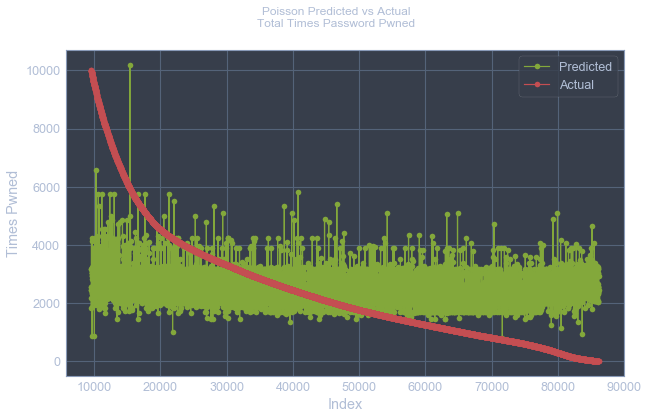

In [25]:
# Create poisson predicted and actual pwned totals to be plotted
pois_pred_cnt = pois_pred_df['mean']
pois_act_cnt = pois_y_test['Total']

# Plot poisson predicted vs actual pwned totals
pois_fig = plt.figure(figsize=(10,6))
pois_fig.suptitle('Poisson Predicted vs Actual\nTotal Times Password Pwned')
pois_pred_plt, = plt.plot(pois_X_test.index, pois_pred_cnt, 'go-', label='Predicted')
pois_act_plt, = plt.plot(pois_X_test.index, pois_act_cnt, 'ro-', label='Actual')
plt.xlabel('Index')
plt.ylabel('Times Pwned')
plt.legend(handles=[pois_pred_plt, pois_act_plt])
plt.show()

In [26]:
# # Save poisson figure
# pois_fig.savefig('Visualizations/poisson.png', dpi=300)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Times Pwned'),
 Text(0.5, 1.0, 'Distribution: Number of Times\nPasswords Pwned')]

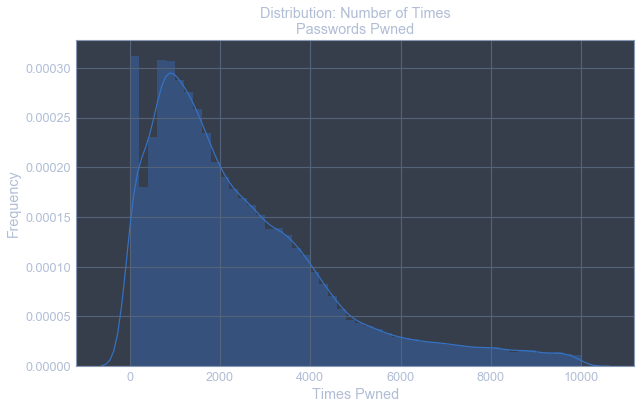

In [27]:
# Plot distribution of num of times passwrods pwned
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(df['Total'])
ax.set(title='Distribution: Number of Times\nPasswords Pwned',
       xlabel='Times Pwned', ylabel='Frequency')

In [29]:
# # Save figure
# fig.savefig('Visualizations/pwned_dist.png', dpi=300)

Distribution is skewed right.

Text(0, 0.5, 'Times Pwned (Mean)')

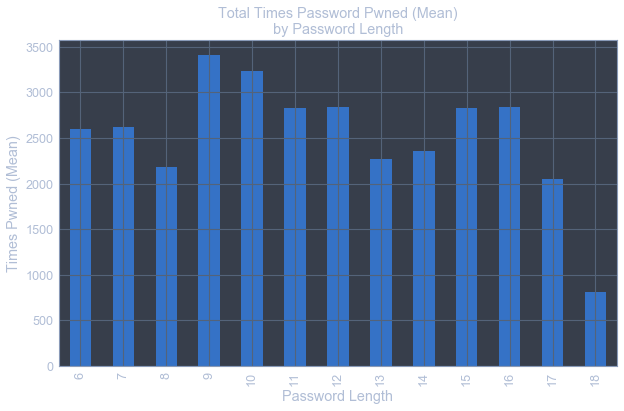

In [30]:
# Plot mean total times pwned by password length
fig, ax = plt.subplots(figsize=(10,6))
ax = df.groupby('Length')['Total'].mean().iloc[:-2].plot(
    kind='bar', title='Total Times Password Pwned (Mean)\nby Password Length')
ax.set_xlabel('Password Length')
ax.set_ylabel('Times Pwned (Mean)')

In [31]:
# # Save figure
# fig.savefig('Visualizations/mean_pwned_by_length', dpi=300)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Password Length'),
 Text(0.5, 1.0, 'Distribution of Pwned Password Lengths')]

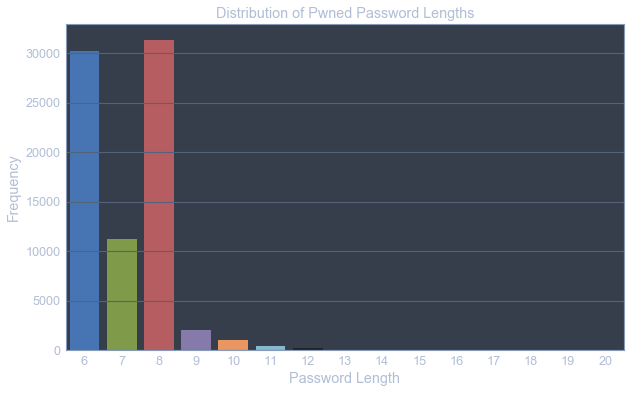

In [33]:
# Plot the distribution of pwned password lengths
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x='Length', data=df)
ax.set(title='Distribution of Pwned Password Lengths', xlabel='Password Length',
       ylabel='Frequency')

In [35]:
# # Save figure
# fig.savefig('Visualizations/pwd_length_dist.png', dpi=300)

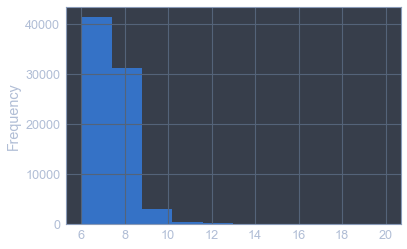

In [27]:
df['Length'].sort_values().plot(kind='hist')

In [59]:
# Plot total pwned by repeated characters
plot_df = df.copy(deep=True)
plot_cond = [plot_df['Rep_2']==1, plot_df['Rep_3']==1, plot_df['Rep_4']==1,
                   plot_df['Rep_5']==1, plot_df['Rep_6']==1, plot_df['Rep_7']==1,
                   plot_df['Rep_8']==1]
plot_chce = ['Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight']
plot_df['Plot'] = np.select(plot_cond, plot_chce, 'Other')

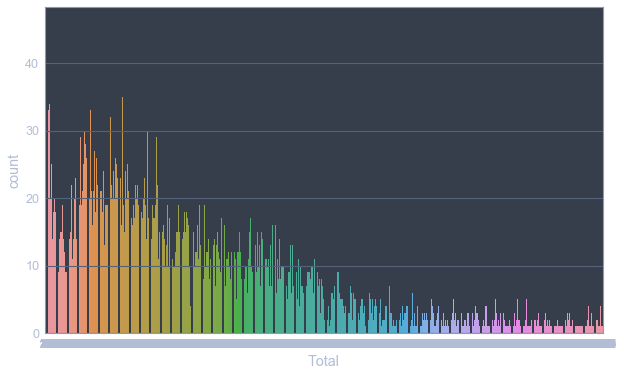

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x='Total', data=plot_df)
plt.show()

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
# sns.set_context('notebook')
ax = sns.countplot(x="channels", data=dropped_news, palette='Set1')
plt.title('Number of Shares per Article Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Shares')

SyntaxError: invalid syntax (<ipython-input-60-abf1e7847fd0>, line 3)

9559     Two
9560     Two
9561     Two
9562     Two
9563     Two
9564     Two
9565     Two
9566     Two
9567     Two
9568     Two
9569     Two
9570     Two
9571     Two
9572     Two
9573     Two
9574     Two
9575     Two
9576     Two
9577     Two
9578     Two
9579     Two
9580     Two
9581     Two
9582     Two
9583     Two
9584     Two
9585     Two
9586     Two
9587     Two
9588     Two
        ... 
86110    Two
86111    Two
86112    Two
86113    Two
86114    Two
86115    Two
86116    Two
86117    Two
86118    Two
86119    Two
86120    Two
86121    Two
86122    Two
86123    Two
86124    Two
86125    Two
86126    Two
86127    Two
86128    Two
86129    Two
86130    Two
86131    Two
86132    Two
86133    Two
86134    Two
86135    Two
86136    Two
86137    Two
86138    Two
86139    Two
Name: channels, Length: 76581, dtype: object